In [1]:
!pip install catboost
!pip install shap

# Imports

In [2]:
import pickle

import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

import shap

%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

import warnings
warnings.filterwarnings("ignore")

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

/root/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load data

In [16]:
filename = 'dataset_KINOPOISK_views.pkl'
with open('../data/' + filename, 'rb') as f:
    raw_df = pickle.load(f, encoding='utf-8')

# work with copy
df = raw_df.copy(deep=True)

In [18]:
df.head().T

,0,1,2,3,4
age_access_type,12,16,18,18,6
name,Звёздный путь 5: Последний рубеж,Звёздный путь 6: Неоткрытая страна,В поисках древнего артефакта,Прожарка Чарли Шина,Пламенное сердце
director,['cff3362f-ad91-498d-80b3-ea3ab8ec65cf'],['bab6b7f4-4506-458f-9091-d567505674f2'],['895f5774-964a-4c5a-ae22-d697d3e3e620'],['1de22aff-430e-4af9-bf1d-159dbf8e9269'],"['40f78e6d-3c9f-434f-a505-c6ffdd045763', '3321..."
genre,"['Sci-Fi', 'Action', 'Thriller', 'Adventure']","['Sci-Fi', 'Action', 'Thriller', 'Adventure']",['Horror'],"['Comedy', 'Documentary']","['Comedy', 'Adventure', 'Family', '287a1485-7a..."
average_rating,6.21,7.2,4.0,6.99,6.4
...,...,...,...,...,...
зебра,0,0,0,0,0
сидень,0,0,0,0,0
беатрис,0,0,0,0,0
рыбка,0,0,0,0,0


# Preprocessing

In [19]:
from src.preprocessing.preprocessing import SimplePreprocessor

target_name = 'target'
filter_release_year = 2000
list_features = {'ACTOR': 10, 'COMPOSER': 3, 'DESIGN': 2, 'DIRECTOR': 2, 'EDITOR': 2,
                 'OPERATOR': 2, 'PRODUCER': 3, 'WRITER': 2, 'country': 5, 'genre': 10}
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

preprocessor = SimplePreprocessor(target_name,
                                  list_features,
                                  skewed_num_features,
                                  filter_release_year)

# Model

In [20]:
cat_features = ['age_access_type', 'type']

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)


# Pipeline

In [21]:

from src.pipeline.pipeline import Pipeline

sc_cols = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']
split_filter_year = 2022

pipeline = Pipeline(
                 mode='ml',
                 preprocessor = preprocessor,
                 model = cat_model, 
                 sandart_scaler_cols = sc_cols,
                 splitting_params = {'test_size': 0.1,
                                     'target_name': 'target',
                                     'split_filter_year': split_filter_year},
                 )

In [22]:

%%time
X_train, X_val, X_test, \
y_train, y_val, y_test = pipeline.prepare_data(df)

2023-05-10 20:44:49,877:DEBUG:Starting preprocessing
2023-05-10 20:44:51,892:DEBUG:Splitting dataset on train, val and test


split_filter_year: 2022
CPU times: user 1.84 s, sys: 295 ms, total: 2.13 s
Wall time: 2.13 s


## Train

In [23]:

train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                        cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                        cat_features=cat_features)

val_dataset = cat.Pool(data=X_val,
                       label=y_val,
                       cat_features=cat_features)

In [24]:
%%time
pipeline.train_ml_model(train_dataset, val_dataset)

2023-05-10 20:44:52,327:INFO:Training model


Learning rate set to 0.056659
0:	learn: 2.2439249	test: 2.7496239	best: 2.7496239 (0)	total: 19.4ms	remaining: 19.4s
100:	learn: 0.6999877	test: 1.1819201	best: 1.1641611 (48)	total: 665ms	remaining: 5.92s
200:	learn: 0.6274537	test: 1.1958184	best: 1.1641611 (48)	total: 1.26s	remaining: 5.03s
300:	learn: 0.5773969	test: 1.1952013	best: 1.1641611 (48)	total: 1.87s	remaining: 4.34s
400:	learn: 0.5416314	test: 1.2121586	best: 1.1641611 (48)	total: 2.48s	remaining: 3.7s
500:	learn: 0.5107042	test: 1.2291256	best: 1.1641611 (48)	total: 3.08s	remaining: 3.07s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.164161135
bestIteration = 48

Shrink model to first 49 iterations.
CPU times: user 2min 15s, sys: 9.36 s, total: 2min 24s
Wall time: 3.44 s


## Predict

In [25]:
%%time
y_pred = pipeline.predict(test_dataset)

2023-05-10 20:44:55,829:INFO:Starting prediction


CPU times: user 1.98 ms, sys: 172 µs, total: 2.16 ms
Wall time: 1.61 ms


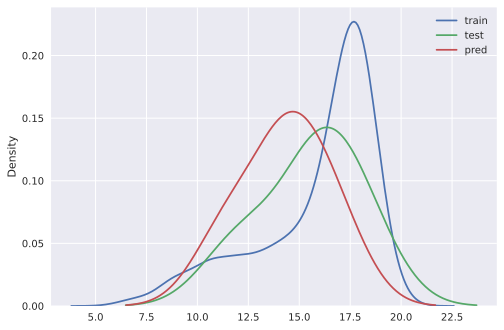

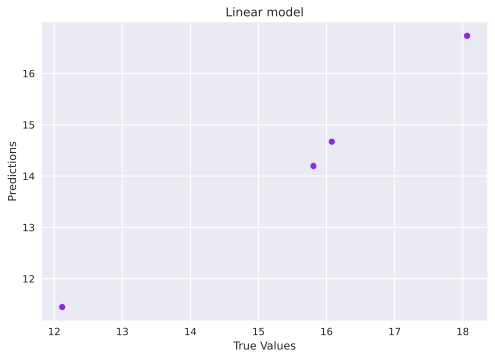

In [26]:
pipeline.draw_curves(y_train, y_test, y_pred)

In [27]:
pipeline.get_scores(y_test, y_pred)

MSE:   1.6980987822510136
RMSE:  1.3031111933565047
R2:    0.6317715365627176
MAE:   1.254261214461311
MedAE: 1.3689337599220464
------------------------------


2023-05-10 20:44:56,234:DEBUG:Getting feature importance


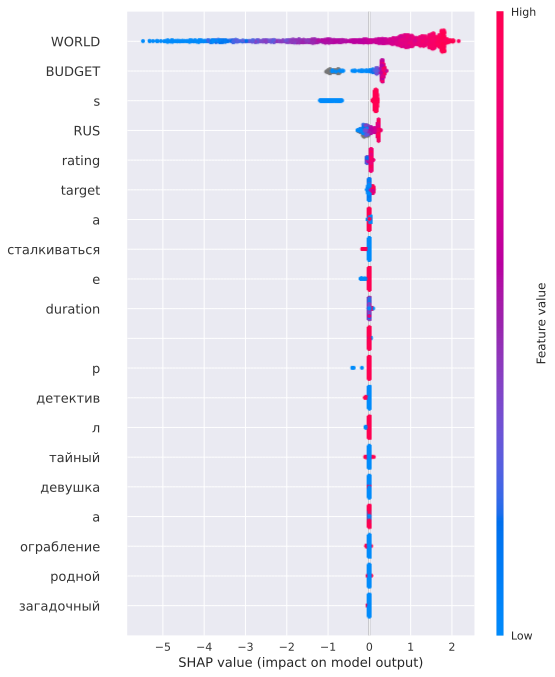

In [28]:
pipeline.get_feature_importance(X_train, y_train, cat_features)

In [29]:
pipeline.save_model(filename='demo_cat_boost_model_VIEWS_1')

2023-05-10 20:45:01,773:DEBUG:Saving model


# Run all in

2023-05-10 20:45:05,528:INFO:Running ML regressor pipeline
2023-05-10 20:45:05,553:DEBUG:Starting preprocessing
2023-05-10 20:45:07,110:DEBUG:Splitting dataset on train, val and test
2023-05-10 20:45:07,283:INFO:Training model


split_filter_year: 2022
Learning rate set to 0.056659
0:	learn: 2.2439249	test: 2.7496239	best: 2.7496239 (0)	total: 12.6ms	remaining: 12.6s
100:	learn: 0.6999877	test: 1.1819201	best: 1.1641611 (48)	total: 644ms	remaining: 5.73s
200:	learn: 0.6274537	test: 1.1958184	best: 1.1641611 (48)	total: 1.26s	remaining: 5.01s
300:	learn: 0.5773969	test: 1.1952013	best: 1.1641611 (48)	total: 1.88s	remaining: 4.36s
400:	learn: 0.5416314	test: 1.2121586	best: 1.1641611 (48)	total: 2.49s	remaining: 3.71s
500:	learn: 0.5107042	test: 1.2291256	best: 1.1641611 (48)	total: 3.12s	remaining: 3.11s


2023-05-10 20:45:10,760:INFO:Starting prediction


Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.164161135
bestIteration = 48

Shrink model to first 49 iterations.


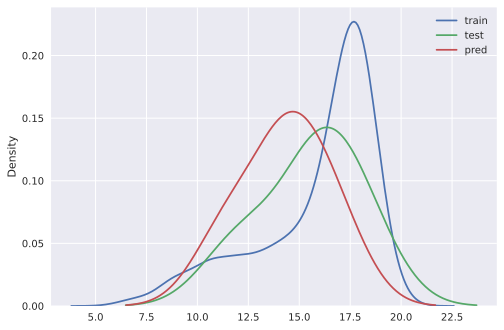

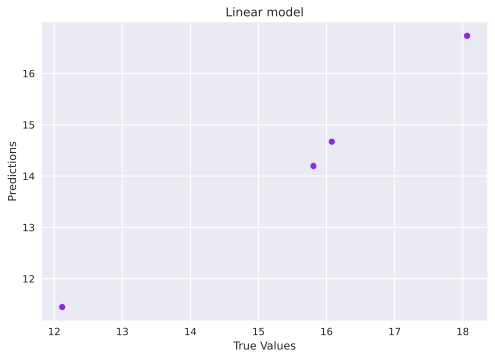

2023-05-10 20:45:10,998:DEBUG:Getting feature importance


MSE:   1.6980987822510136
RMSE:  1.3031111933565047
R2:    0.6317715365627176
MAE:   1.254261214461311
MedAE: 1.3689337599220464
------------------------------


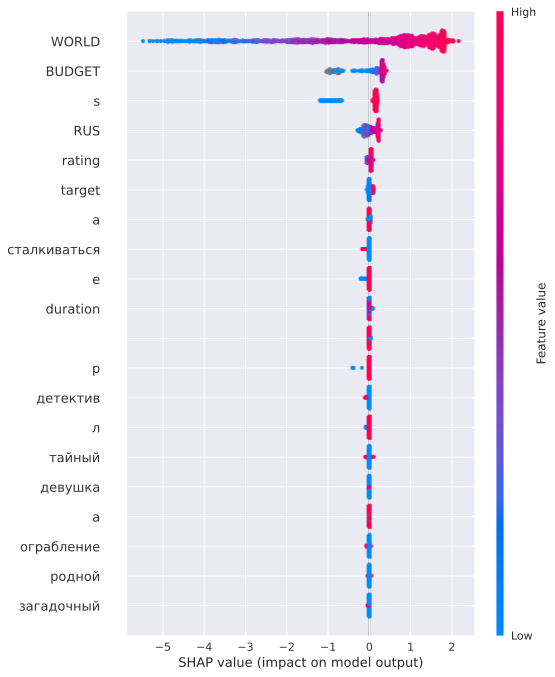

2023-05-10 20:45:12,369:DEBUG:Saving model


In [30]:
pipeline.run_ml_regressor(df, cat_features, model_filename = 'demo_model_views')